In [3]:
import pandas as pd

In [ ]:
df = pd.read_csv('/Users/shubhdeepdas/Desktop/Code/Research_Stuff/Disease Predictor/Final_Augmented_dataset_Diseases_and_Symptoms.csv')

print("Basic info:")
print(df.info())

# 2. List all column names
print("\nColumns:")
print(df.columns.tolist())

# 3. Summary statistics of numeric columns
print("\nSummary statistics:")
print(df.describe())

# 4. Number of unique values in each column (to identify categorical columns)
print("\nUnique values count per column:")
print(df.nunique())

# 5. Sample unique values from 'diseases' column
print("\nUnique values in 'diseases' column:")
print(df['diseases'].unique())

# 6. Data types of all columns
print("\nData types:")
print(df.dtypes)

# 7. Check for any missing values in columns
print("\nMissing values per column:")
print(df.isnull().sum())

# 8. Count of 1s (true values) in symptom columns
symptom_cols = df.columns.difference(['diseases'])
print("\nCount of true (1) values per symptom column:")
print(df[symptom_cols].sum())

# 9. Row with highest number of symptoms true (after ensuring numeric conversion)
df[symptom_cols] = df[symptom_cols].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)
df['symptom_count'] = df[symptom_cols].sum(axis=1)
max_symptoms_row = df.loc[df['symptom_count'].idxmax()]
print("\nRow with highest number of symptoms true:")
print(max_symptoms_row)


Basic info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246945 entries, 0 to 246944
Columns: 378 entries, diseases to neck weakness
dtypes: int64(377), object(1)
memory usage: 712.2+ MB
None

Columns:
['diseases', 'anxiety and nervousness', 'depression', 'shortness of breath', 'depressive or psychotic symptoms', 'sharp chest pain', 'dizziness', 'insomnia', 'abnormal involuntary movements', 'chest tightness', 'palpitations', 'irregular heartbeat', 'breathing fast', 'hoarse voice', 'sore throat', 'difficulty speaking', 'cough', 'nasal congestion', 'throat swelling', 'diminished hearing', 'lump in throat', 'throat feels tight', 'difficulty in swallowing', 'skin swelling', 'retention of urine', 'groin mass', 'leg pain', 'hip pain', 'suprapubic pain', 'blood in stool', 'lack of growth', 'emotional symptoms', 'elbow weakness', 'back weakness', 'pus in sputum', 'symptoms of the scrotum and testes', 'swelling of scrotum', 'pain in testicles', 'flatulence', 'pus draining from ear', 'jaund

/var/folders/km/3fmghfbx0b72rw2zvn_t9y2w0000gn/T/ipykernel_76951/3592207220.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['symptom_count'] = df[symptom_cols].sum(axis=1)


In [66]:
for i in df.columns.to_list():
    if 'art' in i:
        print(i)

irregular heartbeat
heartburn
decreased heart rate
increased heart rate
warts
postpartum problems of the breast


In [23]:
# This code was to make the symptoms list better for RAG Search 

import os
import time
import json
import requests
import pandas as pd

# --------- CONFIG ---------
OLLAMA_URL = "http://localhost:11434/api/generate"
MODEL_NAME = "gemma3:1b"   # or 'deepseek-r1:1.5b', etc.
OUTPUT_CSV = "symptom_metadata.csv"
SLEEP_BETWEEN_CALLS = 0.2   # seconds
MAX_RETRIES_PER_SYMPTOM = 2
# --------------------------


# --- STEP 0: Get symptom list from your dataframe ---

clmn = list(df.columns.unique())
symptms = clmn[1:]  # assuming first column is not a symptom
print("Found", len(symptms), "symptoms")


# --- PROMPT ---

def build_prompt(symptom: str) -> str:
    return f"""
You are helping to standardize symptom names for a medical questionnaire.

SYMPTOM: "{symptom}"

Your task:
Return a JSON object with EXACTLY these keys:
- "symptom": the original symptom name as given.
- "short_description": one short, plain-language description of what the person is feeling in their body or mind no daignosis just description (15–30 words).
- "synonyms": a list of 6–12 natural phrases that real patients might say when describing the SAME symptom in everyday language.

Very important rules:
- NEVER leave "short_description" or "synonyms" empty.
- ALWAYS produce at least 6 synonyms. Prefer 8–10 when possible.
- Synonyms MUST be full phrases, not single words. For example:
  - GOOD: "I feel short of breath", "I can't catch my breath", "I get tired after walking a little"
  - BAD: "breathlessness", "dyspnea", "unease"
- Avoid very technical words unless people commonly say them.
- Do NOT diagnose. Just describe what the person feels (e.g., "feeling very sad and hopeless" instead of "major depressive disorder").
- Use simple English, neutral tone, not dramatic or scary.
- Always talk in third person or generic style (e.g., "feeling…" or "I feel…") – like a patient describing their problem.

Output format:
Return ONLY a valid JSON object, nothing else. Example format (structure only):

{{
  "symptom": "anxiety and nervousness",
  "short_description": "A state of feeling tense, on edge, or worried, often with physical signs like a racing heart or restlessness.",
  "synonyms": [
    "I feel very anxious and restless",
    "I can't stop worrying about everything",
    "my heart keeps racing and I feel on edge",
    "I feel nervous for no clear reason",
    "I feel shaky and tense all the time",
    "I can't relax, my mind is always racing"
  ]
}}
""".strip()


# --- Call Ollama and parse JSON with basic quality check ---

def _single_call(symptom: str) -> dict:
    payload = {
        "model": MODEL_NAME,
        "prompt": build_prompt(symptom),
        "format": "json",
        "stream": False,
    }

    resp = requests.post(OLLAMA_URL, json=payload, timeout=180)
    resp.raise_for_status()
    data = resp.json()

    raw = data.get("response", "")

    try:
        parsed = json.loads(raw)
    except json.JSONDecodeError:
        # Try to rescue a JSON substring
        start = raw.find("{")
        end = raw.rfind("}")
        if start != -1 and end != -1:
            parsed = json.loads(raw[start:end + 1])
        else:
            raise

    # Defaults & normalization
    parsed.setdefault("symptom", symptom)
    parsed.setdefault("short_description", "")
    parsed.setdefault("synonyms", [])

    if not isinstance(parsed["synonyms"], list):
        parsed["synonyms"] = [str(parsed["synonyms"])]

    parsed["synonyms"] = [
        str(s).strip() for s in parsed["synonyms"] if str(s).strip()
    ]

    return parsed


def _is_good_enough(meta: dict) -> bool:
    desc = str(meta.get("short_description", "")).strip()
    syns = meta.get("synonyms", [])
    if not isinstance(syns, list):
        syns = [syns]
    syns = [str(s).strip() for s in syns if str(s).strip()]

    # basic quality criteria – tune as you like
    if len(desc.split()) < 5:  # too short / empty
        return False
    if len(syns) < 4:  # too few synonyms
        return False

    return True


def query_ollama_with_retry(symptom: str, max_retries: int = MAX_RETRIES_PER_SYMPTOM) -> dict:
    last_meta = None
    for attempt in range(1, max_retries + 1):
        try:
            meta = _single_call(symptom)
            last_meta = meta
            if _is_good_enough(meta):
                return meta
            else:
                print(f"    -> Output not good enough (attempt {attempt}). Retrying...")
        except Exception as e:
            print(f"    -> Error calling model on attempt {attempt}: {e}")
        time.sleep(0.5)  # small delay before retry

    # If we reach here, either all attempts failed or never met quality criteria
    print("    -> Using last available output (may be incomplete).")
    if last_meta is None:
        last_meta = {
            "symptom": symptom,
            "short_description": "",
            "synonyms": [],
        }
    return last_meta


# --- Load already processed symptoms if CSV exists ---

processed_symptoms = set()
header_exists = os.path.exists(OUTPUT_CSV)

if header_exists:
    try:
        existing_df = pd.read_csv(OUTPUT_CSV)
        if "symptom" in existing_df.columns:
            processed_symptoms = set(existing_df["symptom"].astype(str).tolist())
            print(f"Resuming: found {len(processed_symptoms)} already processed symptoms.")
        else:
            print(f"Warning: {OUTPUT_CSV} exists but has no 'symptom' column. Treating as empty.")
    except Exception as e:
        print(f"Could not read existing {OUTPUT_CSV}: {e}")
        print("Continuing as if no previous file exists.")
        header_exists = False
        processed_symptoms = set()
else:
    print("No existing CSV found. Starting fresh.")

header_written = header_exists

# --- Loop, query, and APPEND row-by-row ---

for idx, s in enumerate(symptms, start=1):
    s_str = str(s)

    if s_str in processed_symptoms:
        print(f"[{idx}/{len(symptms)}] Skipping already processed symptom: {s_str!r}")
        continue

    print(f"[{idx}/{len(symptms)}] Generating metadata for symptom: {s_str!r}")

    meta = query_ollama_with_retry(s_str)
    desc = str(meta.get("short_description", "")).strip()
    syns_list = meta.get("synonyms", [])
    if not isinstance(syns_list, list):
        syns_list = [syns_list]
    syns_list = [str(x).strip() for x in syns_list if str(x).strip()]

    row_dict = {
        "symptom": meta.get("symptom", s_str),
        "short_description": desc,
        # keep separator; you can change to "|" if you want
        "synonyms": "; ".join(syns_list),
    }

    row_df = pd.DataFrame([row_dict])

    row_df.to_csv(
        OUTPUT_CSV,
        mode="a",
        index=False,
        header=not header_written,
    )

    header_written = True
    processed_symptoms.add(s_str)

    time.sleep(SLEEP_BETWEEN_CALLS)

print("Done. Incremental results saved in:", OUTPUT_CSV)


Found 377 symptoms
No existing CSV found. Starting fresh.
[1/377] Generating metadata for symptom: 'anxiety and nervousness'
[2/377] Generating metadata for symptom: 'depression'
[3/377] Generating metadata for symptom: 'shortness of breath'
[4/377] Generating metadata for symptom: 'depressive or psychotic symptoms'
[5/377] Generating metadata for symptom: 'sharp chest pain'
[6/377] Generating metadata for symptom: 'dizziness'
[7/377] Generating metadata for symptom: 'insomnia'
[8/377] Generating metadata for symptom: 'abnormal involuntary movements'
[9/377] Generating metadata for symptom: 'chest tightness'
[10/377] Generating metadata for symptom: 'palpitations'
[11/377] Generating metadata for symptom: 'irregular heartbeat'
[12/377] Generating metadata for symptom: 'breathing fast'
[13/377] Generating metadata for symptom: 'hoarse voice'
[14/377] Generating metadata for symptom: 'sore throat'
[15/377] Generating metadata for symptom: 'difficulty speaking'
[16/377] Generating metadat

In [37]:
# build_symptom_indices.py

import json
from pathlib import Path

import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer

# === CONFIG ===
CSV_PATH = "/Users/shubhdeepdas/Desktop/Code/Research_Stuff/Disease Predictor/symptom_metadata.csv"
BASE_OUTPUT_DIR = Path("/Users/shubhdeepdas/Desktop/Code/Research_Stuff/Disease Predictor/symptom_index")

# Model configs: key = short name, value = HF model id
MODEL_CONFIGS = {
    "minilm": "sentence-transformers/all-MiniLM-L6-v2",
    "mpnet": "sentence-transformers/all-mpnet-base-v2",
    "biolord": "FremyCompany/BioLORD-2023",  # e.g. "pritamdeka/BioSimCSE-BioClinicalBERT" or your BioLORD id
}
# ==============

df = pd.read_csv(CSV_PATH)


def build_symptom_docs(df: pd.DataFrame):
    """
    Build rich text docs per symptom:
    - name
    - short_description
    - synonyms (split by ';')
    """
    docs = []
    for _, row in df.iterrows():
        name = str(row["symptom"]).strip()
        desc = str(row.get("short_description", "")).strip()
        syns = str(row.get("synonyms", "")).strip()

        syn_list = [s.strip() for s in syns.split(";") if s.strip()]
        syn_text = ". ".join(syn_list)

        text = f"{name}."
        if desc:
            text += f" {desc}"
        if syn_text:
            text += f" Synonyms/phrases: {syn_text}"

        docs.append({"name": name, "text": text})
    return docs


def build_and_save_index(model_key: str, model_name: str, docs: list[dict]):
    print(f"\n=== Building index for [{model_key}] -> {model_name} ===")

    # Prepare output dir for this model
    output_dir = BASE_OUTPUT_DIR / model_key
    output_dir.mkdir(parents=True, exist_ok=True)

    # Extract texts/names
    symptom_texts = [d["text"] for d in docs]
    symptom_names = [d["name"] for d in docs]

    print(f"Encoding {len(symptom_texts)} symptom docs with {model_name} ...")
    model = SentenceTransformer(model_name)

    symptom_embs = model.encode(symptom_texts, normalize_embeddings=True)
    symptom_embs = np.array(symptom_embs)

    print("Embeddings shape:", symptom_embs.shape)

    # Save embeddings + meta
    emb_path = output_dir / "symptom_embs.npy"
    meta_path = output_dir / "symptom_meta.json"

    np.save(emb_path, symptom_embs)

    with open(meta_path, "w") as f:
        json.dump(
            {
                "model_name": model_name,
                "symptom_names": symptom_names,
                "symptom_texts": symptom_texts,
            },
            f,
            indent=2,
        )

    print(f"Saved embeddings to {emb_path}")
    print(f"Saved metadata to {meta_path}")


def main():
    symptom_docs = build_symptom_docs(df)
    print(f"Built {len(symptom_docs)} symptom docs from CSV.")

    for key, model_name in MODEL_CONFIGS.items():
        if "REPLACE_WITH_BIOLORD_MODEL_NAME" in model_name:
            print(
                f"\n[WARN] Skipping model '{key}' because it still has the placeholder name. "
                "Edit MODEL_CONFIGS to set the actual BioLORD model id."
            )
            continue
        build_and_save_index(key, model_name, symptom_docs)


if __name__ == "__main__":
    main()


Built 377 symptom docs from CSV.

=== Building index for [minilm] -> sentence-transformers/all-MiniLM-L6-v2 ===
Encoding 377 symptom docs with sentence-transformers/all-MiniLM-L6-v2 ...
Embeddings shape: (377, 384)
Saved embeddings to /Users/shubhdeepdas/Desktop/Code/Research_Stuff/Disease Predictor/symptom_index/minilm/symptom_embs.npy
Saved metadata to /Users/shubhdeepdas/Desktop/Code/Research_Stuff/Disease Predictor/symptom_index/minilm/symptom_meta.json

=== Building index for [mpnet] -> sentence-transformers/all-mpnet-base-v2 ===
Encoding 377 symptom docs with sentence-transformers/all-mpnet-base-v2 ...
Embeddings shape: (377, 768)
Saved embeddings to /Users/shubhdeepdas/Desktop/Code/Research_Stuff/Disease Predictor/symptom_index/mpnet/symptom_embs.npy
Saved metadata to /Users/shubhdeepdas/Desktop/Code/Research_Stuff/Disease Predictor/symptom_index/mpnet/symptom_meta.json

=== Building index for [biolord] -> FremyCompany/BioLORD-2023 ===
Encoding 377 symptom docs with FremyCompany

Loaded index for model 'minilm': sentence-transformers/all-MiniLM-L6-v2
Loaded index for model 'mpnet': sentence-transformers/all-mpnet-base-v2
Loaded index for model 'biolord': FremyCompany/BioLORD-2023

QUERY: my stomach has been hurting badly since yesterday

Top matches for model [minilm] (sentence-transformers/all-MiniLM-L6-v2):
model_key  rank                symptom    score
   minilm     1 burning abdominal pain 0.439499
   minilm     2   sharp abdominal pain 0.428654
   minilm     3   upper abdominal pain 0.425287
   minilm     4               diarrhea 0.393998
   minilm     5        swollen abdomen 0.391960
   minilm     6       stomach bloating 0.389772
   minilm     7                 nausea 0.369956
   minilm     8  pain during pregnancy 0.367863
   minilm     9          regurgitation 0.361161
   minilm    10              heartburn 0.360048
   minilm    11            pelvic pain 0.355834
   minilm    12        regurgitation.1 0.350963

Top matches for model [mpnet] (sentence

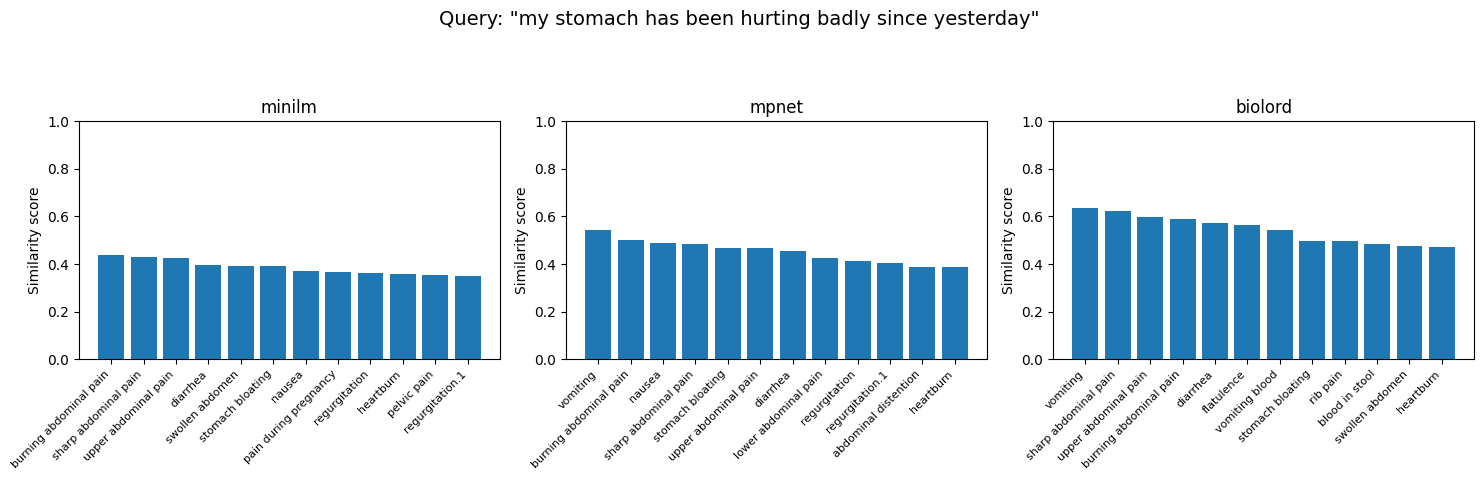


QUERY: I feel really dizzy and the room spins when I stand up

Top matches for model [minilm] (sentence-transformers/all-MiniLM-L6-v2):
model_key  rank              symptom    score
   minilm     1            dizziness 0.510173
   minilm     2         restlessness 0.403977
   minilm     3        back weakness 0.388153
   minilm     4             fainting 0.374580
   minilm     5 eye moves abnormally 0.370460
   minilm     6           sleepiness 0.347977
   minilm     7         leg weakness 0.327320
   minilm     8    low back weakness 0.318823
   minilm     9           cross-eyed 0.308893
   minilm    10 difficulty breathing 0.301603
   minilm    11  shortness of breath 0.298502
   minilm    12         sleepwalking 0.288348

Top matches for model [mpnet] (sentence-transformers/all-mpnet-base-v2):
model_key  rank                          symptom    score
    mpnet     1                        dizziness 0.644621
    mpnet     2             eye moves abnormally 0.486363
    mpnet     3  

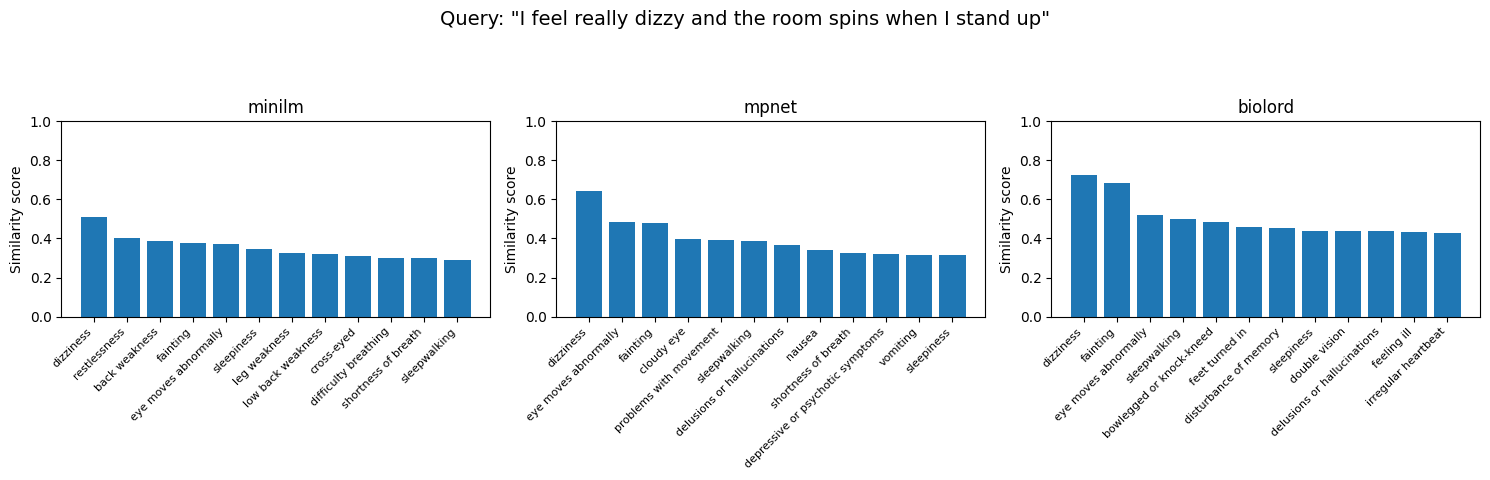


QUERY: I can't stop worrying and my heart keeps racing all the time

Top matches for model [minilm] (sentence-transformers/all-MiniLM-L6-v2):
model_key  rank                    symptom    score
   minilm     1    anxiety and nervousness 0.522933
   minilm     2        irregular heartbeat 0.380053
   minilm     3          fears and phobias 0.378255
   minilm     4       increased heart rate 0.370746
   minilm     5               palpitations 0.364460
   minilm     6         recent weight loss 0.331591
   minilm     7 unpredictable menstruation 0.319000
   minilm     8                  hesitancy 0.292357
   minilm     9 obsessions and compulsions 0.285829
   minilm    10        congestion in chest 0.282274
   minilm    11       difficulty breathing 0.271902
   minilm    12       feeling hot and cold 0.264004

Top matches for model [mpnet] (sentence-transformers/all-mpnet-base-v2):
model_key  rank                    symptom    score
    mpnet     1    anxiety and nervousness 0.403426
   

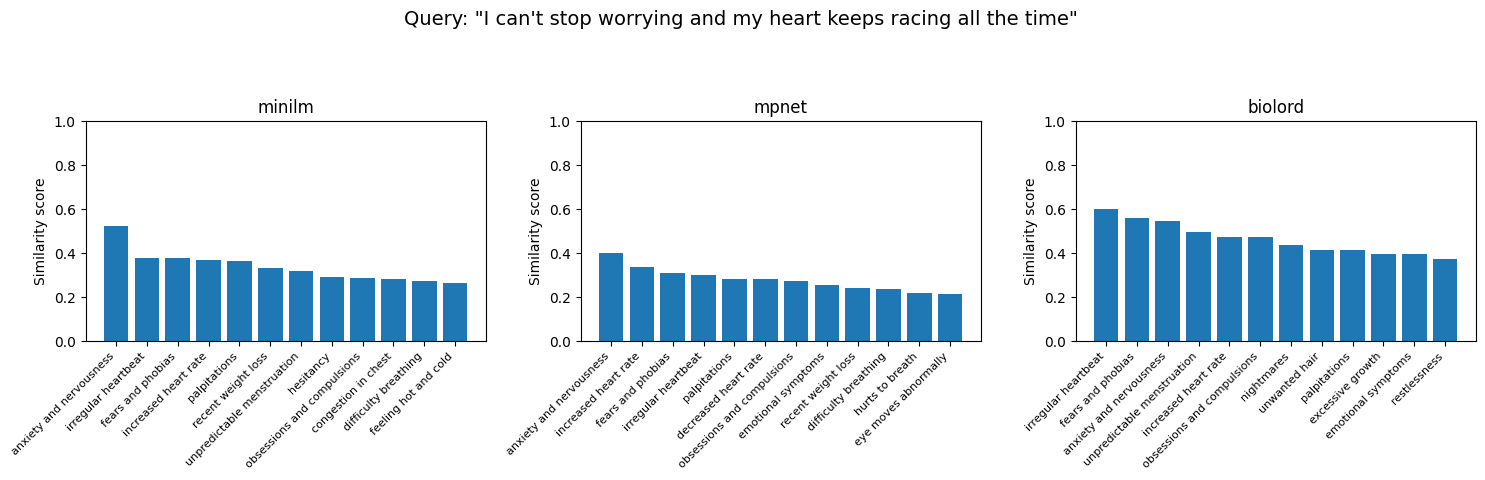


################################################################################
COMBINED RESULTS (all queries, all models)
################################################################################
                                                       query model_key  rank                          symptom    score
I can't stop worrying and my heart keeps racing all the time   biolord     1              irregular heartbeat 0.602952
I can't stop worrying and my heart keeps racing all the time   biolord     2                fears and phobias 0.560946
I can't stop worrying and my heart keeps racing all the time   biolord     3          anxiety and nervousness 0.547086
I can't stop worrying and my heart keeps racing all the time   biolord     4       unpredictable menstruation 0.495143
I can't stop worrying and my heart keeps racing all the time   biolord     5             increased heart rate 0.475473
I can't stop worrying and my heart keeps racing all the time   biolord     6    

In [46]:
# compare_embedding_models.py

import json
from pathlib import Path

import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt

BASE_INDEX_DIR = Path("/Users/shubhdeepdas/Desktop/Code/Research_Stuff/Disease Predictor/symptom_index")

# Must match the folder names used in build_symptom_indices.py
MODEL_KEYS = ["minilm", "mpnet", "biolord"]

# Some example "patient sentences" to test
TEST_QUERIES = [
    "my stomach has been hurting badly since yesterday",
    "I feel really dizzy and the room spins when I stand up",
    "I can't stop worrying and my heart keeps racing all the time",
]


def load_index(model_key: str):
    """
    Load embeddings + meta for a given model_key (minilm/mpnet/biolord).
    """
    index_dir = BASE_INDEX_DIR / model_key
    emb_path = index_dir / "symptom_embs.npy"
    meta_path = index_dir / "symptom_meta.json"

    if not emb_path.exists() or not meta_path.exists():
        raise FileNotFoundError(
            f"Index files not found for model '{model_key}' in {index_dir}. "
            "Did you run build_symptom_indices.py and configure the model names correctly?"
        )

    symptom_embs = np.load(emb_path)
    with open(meta_path) as f:
        meta = json.load(f)

    symptom_names = meta["symptom_names"]
    symptom_texts = meta["symptom_texts"]
    model_name = meta["model_name"]

    return {
        "model_key": model_key,
        "model_name": model_name,
        "symptom_embs": symptom_embs,
        "symptom_names": symptom_names,
        "symptom_texts": symptom_texts,
    }


def evaluate_query_on_model(query: str, index: dict, top_k: int = 12):
    """
    For one query and one model, return a list of dicts:
    [
      {"query": ..., "model_key": ..., "model_name": ..., "rank": 1, "symptom": ..., "score": ...},
      ...
    ]
    """
    model_name = index["model_name"]
    model_key = index["model_key"]
    symptom_embs = index["symptom_embs"]
    symptom_names = index["symptom_names"]

    model = SentenceTransformer(model_name)

    q_emb = model.encode([query], normalize_embeddings=True)
    sims = util.cos_sim(q_emb, symptom_embs).cpu().numpy()[0]

    top_idx = sims.argsort()[::-1][:top_k]

    results = []
    for rank, idx in enumerate(top_idx, start=1):
        results.append(
            {
                "query": query,
                "model_key": model_key,
                "model_name": model_name,
                "rank": rank,
                "symptom": symptom_names[idx],
                "score": float(sims[idx]),
            }
        )
    return results


def plot_query_results(query: str, per_model_rows: dict, top_k: int = 12):
    """
    per_model_rows: { model_key: [rows from evaluate_query_on_model] }
    Creates a matplotlib figure with one subplot per model:
    x-axis = symptom (top-k), y-axis = similarity score.
    """
    num_models = len(per_model_rows)
    if num_models == 0:
        return

    fig, axes = plt.subplots(1, num_models, figsize=(5 * num_models, 5), squeeze=False)
    fig.suptitle(f'Query: "{query}"', fontsize=14)

    for col_idx, (model_key, rows) in enumerate(per_model_rows.items()):
        ax = axes[0, col_idx]
        if not rows:
            ax.set_title(f"{model_key} (no results)")
            ax.axis("off")
            continue

        df = pd.DataFrame(rows).sort_values(by="rank")
        # Truncate long symptom names for display, but keep actual label as full on x-axis if you want
        x_labels = df["symptom"].tolist()
        y_scores = df["score"].tolist()

        x_pos = np.arange(len(x_labels))
        ax.bar(x_pos, y_scores)
        ax.set_ylim(0, 1.0)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(x_labels, rotation=45, ha="right", fontsize=8)
        model_name_short = df["model_key"].iloc[0]
        ax.set_title(model_name_short)
        ax.set_ylabel("Similarity score")

    plt.tight_layout(rect=[0, 0.03, 1, 0.90])
    plt.show()


def main():
    # Load all available indices
    indices = {}
    for key in MODEL_KEYS:
        try:
            idx = load_index(key)
            indices[key] = idx
            print(f"Loaded index for model '{key}': {idx['model_name']}")
        except FileNotFoundError as e:
            print(f"[WARN] {e}")
        except Exception as e:
            print(f"[WARN] Failed to load model '{key}': {e}")

    if not indices:
        print("No models loaded. Fix the warnings above and rerun.")
        return

    all_rows = []

    for query in TEST_QUERIES:
        print("\n" + "=" * 80)
        print(f"QUERY: {query}")
        print("=" * 80)

        per_model_rows = {}

        for key, idx in indices.items():
            rows = evaluate_query_on_model(query, idx, top_k=12)
            per_model_rows[key] = rows
            all_rows.extend(rows)

            df = pd.DataFrame(rows)
            display_df = df[["model_key", "rank", "symptom", "score"]]
            print(f"\nTop matches for model [{key}] ({idx['model_name']}):")
            print(display_df.to_string(index=False))

        # Plot a figure comparing all models for this query
        plot_query_results(query, per_model_rows, top_k=12)

    # Optional: combined big table for documentation
    print("\n" + "#" * 80)
    print("COMBINED RESULTS (all queries, all models)")
    print("#" * 80)
    combined_df = pd.DataFrame(all_rows)
    combined_df = combined_df[["query", "model_key", "rank", "symptom", "score"]]
    combined_df = combined_df.sort_values(by=["query", "model_key", "rank"])
    print(combined_df.to_string(index=False))


if __name__ == "__main__":
    main()


In [49]:
import json
from pathlib import Path
from typing import List, Dict, Any

import numpy as np
import pandas as pd
import requests
from sentence_transformers import SentenceTransformer, util
from IPython.display import display  # <- so you can use display(df)

# ===================== CONFIG =====================

# Base project dir
BASE_DIR = Path("/Users/shubhdeepdas/Desktop/Code/Research_Stuff/Disease Predictor")

# CSV and index
CSV_PATH = BASE_DIR / "symptom_metadata.csv"
INDEX_DIR = BASE_DIR / "symptom_index" / "minilm"  # using MiniLM index

# Conversation JSON
CONV_PATH = BASE_DIR / "conversations" / "conv-1.json"

# Ollama config
OLLAMA_URL = "http://localhost:11434/api/generate"
OLLAMA_MODEL = "qwen2.5:7b-instruct"  # or your chosen local model

TOP_K_PER_TURN = 5
MAX_CANDIDATES = 60

# ==================================================


def load_symptom_index(index_dir: Path):
    emb_path = index_dir / "symptom_embs.npy"
    meta_path = index_dir / "symptom_meta.json"

    symptom_embs = np.load(emb_path)
    with open(meta_path) as f:
        meta = json.load(f)

    symptom_names = meta["symptom_names"]
    symptom_texts = meta["symptom_texts"]
    model_name = meta["model_name"]

    model = SentenceTransformer(model_name)

    return {
        "embs": symptom_embs,
        "names": symptom_names,
        "texts": symptom_texts,
        "model": model,
        "model_name": model_name,
    }


def load_symptom_descriptions(csv_path: Path) -> Dict[str, str]:
    """
    Map symptom name -> short_description from your CSV.
    """
    df = pd.read_csv(csv_path)
    desc_map = {}
    for _, row in df.iterrows():
        name = str(row["symptom"]).strip()
        desc = str(row.get("short_description", "")).strip()
        desc_map[name] = desc
    return desc_map


def load_conversation(conv_path: Path) -> List[Dict[str, Any]]:
    with open(conv_path) as f:
        data = json.load(f)
    return data  # [{speaker, message}, ...]


def build_turn_text(turn: Dict[str, Any]) -> str:
    return f'{turn["speaker"].upper()}: {turn["message"].strip()}'


def retrieve_top_symptoms_for_text(
    text: str,
    model: SentenceTransformer,
    symptom_embs: np.ndarray,
    symptom_names: List[str],
    top_k: int = 5,
) -> List[Dict[str, Any]]:
    """
    Return top_k symptoms for this text: [{symptom, score}, ...]
    """
    q_emb = model.encode([text], normalize_embeddings=True)
    sims = util.cos_sim(q_emb, symptom_embs).cpu().numpy()[0]
    top_idx = sims.argsort()[::-1][:top_k]

    results = []
    for idx in top_idx:
        results.append(
            {
                "symptom": symptom_names[idx],
                "score": float(sims[idx]),
            }
        )
    return results


def build_turns_dataframe(
    conversation: List[Dict[str, Any]],
    index: Dict[str, Any],
    top_k: int = 5,
) -> pd.DataFrame:
    """
    For each turn in the conversation, retrieve top-k symptoms and build a DataFrame.
    """
    rows = []
    symptom_embs = index["embs"]
    symptom_names = index["names"]
    model = index["model"]

    for i, turn in enumerate(conversation):
        text = build_turn_text(turn)
        top_symptoms = retrieve_top_symptoms_for_text(
            text, model, symptom_embs, symptom_names, top_k=top_k
        )
        rows.append(
            {
                "turn_idx": i,
                "speaker": turn["speaker"],
                "message": turn["message"],
                "top_symptoms": [t["symptom"] for t in top_symptoms],
                "scores": [t["score"] for t in top_symptoms],
            }
        )

    df = pd.DataFrame(rows)
    return df


def build_conversation_block(conversation: List[Dict[str, Any]]) -> str:
    lines = [build_turn_text(t) for t in conversation]
    return "\n".join(lines)


def call_ollama(prompt: str, model: str = OLLAMA_MODEL) -> str:
    payload = {
        "model": model,
        "prompt": prompt,
        "stream": False,
    }
    resp = requests.post(OLLAMA_URL, json=payload)
    resp.raise_for_status()
    data = resp.json()
    return data["response"]


def build_llm_prompt_for_final_symptoms(
    conversation: List[Dict[str, Any]],
    candidate_symptoms: List[str],
    symptom_descriptions: Dict[str, str],
) -> str:
    conv_text = build_conversation_block(conversation)

    # Build candidate symptom block with short descriptions
    lines = []
    for name in candidate_symptoms:
        desc = symptom_descriptions.get(name, "")
        if desc:
            lines.append(f"- {name}: {desc}")
        else:
            lines.append(f"- {name}")
    candidates_block = "\n".join(lines)

    prompt = f"""
You are a medical assistant that identifies which symptoms a patient currently has
based on a doctor–patient conversation.

You will be given:
- A conversation with clear speaker labels "DOCTOR:" and "PATIENT:".
- A list of candidate symptom names (and short descriptions).

Rules:
- A symptom should be marked PRESENT only if:
  1) The PATIENT clearly describes that symptom in their own words, OR
  2) The DOCTOR asks directly about that symptom and the PATIENT clearly confirms it
     (e.g. "yes", "yeah", "a little", "sometimes", or describes it as present).

- If the PATIENT clearly denies a symptom (e.g. "no chest pain", "no", "not really"),
  do NOT mark that symptom as present.

- If the DOCTOR mentions a symptom only as a possibility or question and the patient
  does NOT clearly confirm it, do NOT mark it as present.

- Focus on current or recent symptoms relevant to this visit.
  Ignore remote historical symptoms no longer present.

- Use ONLY the candidate symptom names provided.

Output:
Return ONLY valid JSON of the form:

{{
  "symptoms_present": ["symptom_name_1", "symptom_name_2", ...]
}}

Do not add any other keys or commentary.

Conversation:
\"\"\" 
{conv_text}
\"\"\"

Candidate symptoms:
{candidates_block}
"""
    return prompt, conv_text  # return conv_text so we can display it later


def main():
    # 1) Load symptom index (MiniLM)
    index = load_symptom_index(INDEX_DIR)
    print(f"Loaded MiniLM index with {len(index['names'])} symptoms.")
    print(f"Using embedding model: {index['model_name']}")

    # 2) Load symptom descriptions
    symptom_desc_map = load_symptom_descriptions(CSV_PATH)

    # 3) Load conversation
    conversation = load_conversation(CONV_PATH)
    print(f"Loaded conversation with {len(conversation)} turns.\n")

    # 4) Build per-turn retrieval DataFrame
    df_turns = build_turns_dataframe(conversation, index, top_k=TOP_K_PER_TURN)

    print("Per-turn candidate symptoms (DataFrame):")
    display(df_turns[["turn_idx", "speaker", "message", "top_symptoms", "scores"]])

    # 5) Build union of candidate symptoms across all turns
    all_candidates = set()
    for syms in df_turns["top_symptoms"]:
        all_candidates.update(syms)

    candidate_list = sorted(list(all_candidates))[:MAX_CANDIDATES]

    print("\nConcatenated / union list of candidate symptoms (as DataFrame):")
    df_candidates = pd.DataFrame({"candidate_symptom": candidate_list})
    display(df_candidates)

    # 6) Build LLM prompt (also get conv_text for display)
    prompt, conv_text = build_llm_prompt_for_final_symptoms(
        conversation, candidate_list, symptom_desc_map
    )

    print("\nFull conversation text passed to LLM:")
    print("------------------------------------------------------------")
    print(conv_text)
    print("------------------------------------------------------------")

    # 7) Call Ollama
    print("\nCalling Ollama for final symptom presence...")
    llm_raw = call_ollama(prompt, model=OLLAMA_MODEL)

    print("\nRaw LLM response:")
    print("------------------------------------------------------------")
    print(llm_raw)
    print("------------------------------------------------------------")

    # 8) Parse JSON
    llm_json = None
    try:
        llm_json = json.loads(llm_raw)
    except json.JSONDecodeError:
        try:
            start = llm_raw.index("{")
            end = llm_raw.rindex("}") + 1
            llm_json = json.loads(llm_raw[start:end])
        except Exception as e:
            print("Failed to parse JSON from LLM:", e)
            return

    symptoms_present = llm_json.get("symptoms_present", [])

    print("\nFinal symptoms present according to LLM (as DataFrame):")
    df_final = pd.DataFrame({"symptom": symptoms_present})
    display(df_final)


if __name__ == "__main__":
    main()


Loaded MiniLM index with 377 symptoms.
Using embedding model: sentence-transformers/all-MiniLM-L6-v2
Loaded conversation with 17 turns.

Per-turn candidate symptoms (DataFrame):


,turn_idx,speaker,message,top_symptoms,scores
0,0,Doctor,Good morning. How are you feeling today?,"[feeling ill, sleepiness, increased heart rate...","[0.4250568151473999, 0.3665846586227417, 0.331..."
1,1,Patient,"Good morning, doctor. I've been feeling a bit ...","[feeling ill, sleepiness, fatigue, recent weig...","[0.4727005064487457, 0.40603166818618774, 0.40..."
2,2,Doctor,I see. Can you tell me more about what you’ve ...,"[mass or swelling around the anus, cloudy eye,...","[0.42108649015426636, 0.4167355000972748, 0.39..."
3,3,Patient,"Well, I feel tired all the time, even after sl...","[sleepiness, fatigue, insomnia, eye strain, he...","[0.5923658609390259, 0.5198987722396851, 0.442..."
4,4,Doctor,How long have you been feeling this way?,"[recent weight loss, feeling ill, anxiety and ...","[0.39236921072006226, 0.3876936435699463, 0.35..."
5,5,Patient,It's been going on for about a week now.,"[change in skin mole size or color, leg lump o...","[0.2886980175971985, 0.27980947494506836, 0.26..."
6,6,Doctor,"Any other symptoms, like trouble sleeping or c...","[difficulty eating, decreased appetite, recent...","[0.5243058204650879, 0.5154721140861511, 0.464..."
7,7,Patient,"Actually, yes. I've had trouble falling asleep...","[decreased appetite, difficulty eating, sleepi...","[0.4460548162460327, 0.392599493265152, 0.3776..."
8,8,Doctor,"Okay, and have you noticed anything that makes...","[feeling ill, swollen lymph nodes, cloudy eye,...","[0.39185547828674316, 0.36103785037994385, 0.3..."
9,9,Patient,"Not really. Rest helps a little, but the tired...","[fatigue, sleepiness, insomnia, restlessness, ...","[0.5026041865348816, 0.4588342010974884, 0.365..."



Concatenated / union list of candidate symptoms (as DataFrame):


,candidate_symptom
0,anxiety and nervousness
1,change in skin mole size or color
2,cloudy eye
3,decreased appetite
4,delusions or hallucinations
5,depression
6,depressive or psychotic symptoms
7,difficulty breathing
8,difficulty eating
9,disturbance of memory



Full conversation text passed to LLM:
------------------------------------------------------------
DOCTOR: Good morning. How are you feeling today?
PATIENT: Good morning, doctor. I've been feeling a bit off lately, just not myself.
DOCTOR: I see. Can you tell me more about what you’ve been experiencing?
PATIENT: Well, I feel tired all the time, even after sleeping well. And sometimes I get headaches, but they’re not too bad.
DOCTOR: How long have you been feeling this way?
PATIENT: It's been going on for about a week now.
DOCTOR: Any other symptoms, like trouble sleeping or changes in appetite?
PATIENT: Actually, yes. I've had trouble falling asleep and I’m not very hungry most days.
DOCTOR: Okay, and have you noticed anything that makes you feel better or worse?
PATIENT: Not really. Rest helps a little, but the tiredness comes back quickly.
DOCTOR: Have you been under a lot of stress recently?
PATIENT: Yes, work has been pretty hectic and I’ve been worried about some deadlines.
DOCTO

,symptom
0,fatigue
1,headache
2,decreased appetite
3,insomnia
4,anxiety and nervousness
5,feeling ill


In [67]:
import json
from pathlib import Path
from typing import List, Dict, Any

import numpy as np
import pandas as pd
import requests
from IPython.display import display
from sentence_transformers import SentenceTransformer, util

# ===================== CONFIG =====================

# Base project dir
BASE_DIR = Path("/Users/shubhdeepdas/Desktop/Code/Research_Stuff/Disease Predictor")

# Symptom CSV and index
CSV_PATH = BASE_DIR / "symptom_metadata.csv"
INDEX_DIR = BASE_DIR / "symptom_index" / "minilm"  # using MiniLM index

# Conversation JSON
CONV_PATH = BASE_DIR / "conversations" / "conv-1.json"

# Disease–symptom matrix CSV
DISEASE_CSV_PATH = (
    BASE_DIR
    / "Final_Augmented_dataset_Diseases_and_Symptoms.csv"
)

# Where to save results (CSVs & logs)
RESULTS_DIR = BASE_DIR / "results"

# Ollama config
OLLAMA_URL = "http://localhost:11434/api/generate"
OLLAMA_MODEL = "qwen2.5:7b-instruct"  # or your chosen local model

TOP_K_PER_TURN = 5
MAX_CANDIDATES = 60

# Disease column name
DISEASE_COL = "diseases"

# ==================================================
# SYMPTOM / CONVERSATION HELPERS
# ==================================================


def load_symptom_index(index_dir: Path) -> Dict[str, Any]:
    emb_path = index_dir / "symptom_embs.npy"
    meta_path = index_dir / "symptom_meta.json"

    symptom_embs = np.load(emb_path)
    with open(meta_path) as f:
        meta = json.load(f)

    symptom_names = meta["symptom_names"]
    symptom_texts = meta["symptom_texts"]
    model_name = meta["model_name"]

    model = SentenceTransformer(model_name)

    return {
        "embs": symptom_embs,
        "names": symptom_names,
        "texts": symptom_texts,
        "model": model,
        "model_name": model_name,
    }


def load_symptom_descriptions(csv_path: Path) -> Dict[str, str]:
    """
    Map symptom name -> short_description from your CSV.
    """
    df = pd.read_csv(csv_path)
    desc_map: Dict[str, str] = {}
    for _, row in df.iterrows():
        name = str(row["symptom"]).strip()
        desc = str(row.get("short_description", "")).strip()
        desc_map[name] = desc
    return desc_map


def load_conversation(conv_path: Path) -> List[Dict[str, Any]]:
    with open(conv_path) as f:
        data = json.load(f)
    return data  # [{speaker, message}, ...]


def build_turn_text(turn: Dict[str, Any]) -> str:
    return f'{turn["speaker"].upper()}: {turn["message"].strip()}'


def retrieve_top_symptoms_for_text(
    text: str,
    model: SentenceTransformer,
    symptom_embs: np.ndarray,
    symptom_names: List[str],
    top_k: int = 5,
) -> List[Dict[str, Any]]:
    """
    Return top_k symptoms for this text: [{symptom, score}, ...]
    """
    q_emb = model.encode([text], normalize_embeddings=True)
    sims = util.cos_sim(q_emb, symptom_embs).cpu().numpy()[0]
    top_idx = sims.argsort()[::-1][:top_k]

    results: List[Dict[str, Any]] = []
    for idx in top_idx:
        results.append(
            {
                "symptom": symptom_names[idx],
                "score": float(sims[idx]),
            }
        )
    return results


def build_turns_dataframe(
    conversation: List[Dict[str, Any]],
    index: Dict[str, Any],
    top_k: int = 5,
) -> pd.DataFrame:
    """
    For each turn in the conversation, retrieve top-k symptoms and build a DataFrame.
    """
    rows = []
    symptom_embs = index["embs"]
    symptom_names = index["names"]
    model = index["model"]

    for i, turn in enumerate(conversation):
        text = build_turn_text(turn)
        top_symptoms = retrieve_top_symptoms_for_text(
            text, model, symptom_embs, symptom_names, top_k=top_k
        )
        rows.append(
            {
                "turn_idx": i,
                "speaker": turn["speaker"],
                "message": turn["message"],
                "top_symptoms": [t["symptom"] for t in top_symptoms],
                "scores": [t["score"] for t in top_symptoms],
            }
        )

    df = pd.DataFrame(rows)
    return df


def build_conversation_block(conversation: List[Dict[str, Any]]) -> str:
    lines = [build_turn_text(t) for t in conversation]
    return "\n".join(lines)


def call_ollama(prompt: str, model: str = OLLAMA_MODEL) -> str:
    payload = {
        "model": model,
        "prompt": prompt,
        "stream": False,
    }
    resp = requests.post(OLLAMA_URL, json=payload)
    resp.raise_for_status()
    data = resp.json()
    return data["response"]


def build_llm_prompt_for_final_symptoms(
    conversation: List[Dict[str, Any]],
    candidate_symptoms: List[str],
    symptom_descriptions: Dict[str, str],
) -> tuple[str, str]:
    conv_text = build_conversation_block(conversation)

    # Build candidate symptom block with short descriptions
    lines = []
    for name in candidate_symptoms:
        desc = symptom_descriptions.get(name, "")
        if desc:
            lines.append(f"- {name}: {desc}")
        else:
            lines.append(f"- {name}")
    candidates_block = "\n".join(lines)

    prompt = f"""
You are a medical assistant that identifies which symptoms a patient currently has
based on a doctor–patient conversation.

You will be given:
- A conversation with clear speaker labels "DOCTOR:" and "PATIENT:".
- A list of candidate symptom names (and short descriptions).

Rules:
- A symptom should be marked PRESENT only if:
  1) The PATIENT clearly describes that symptom in their own words, OR
  2) The DOCTOR asks directly about that symptom and the PATIENT clearly confirms it
     (e.g. "yes", "yeah", "a little", "sometimes", or describes it as present).

- If the PATIENT clearly denies a symptom (e.g. "no chest pain", "no", "not really"),
  do NOT mark that symptom as present.

- If the DOCTOR mentions a symptom only as a possibility or question and the patient
  does NOT clearly confirm it, do NOT mark it as present.

- Focus on current or recent symptoms relevant to this visit.
  Ignore remote historical symptoms no longer present.

- Use ONLY the candidate symptom names provided.

Output:
Return ONLY valid JSON of the form:

{{
  "symptoms_present": ["symptom_name_1", "symptom_name_2", ...]
}}

Do not add any other keys or commentary.

Conversation:
\"\"\" 
{conv_text}
\"\"\"

Candidate symptoms:
{candidates_block}
"""
    # return conv_text so we can display & save it
    return prompt, conv_text


# ==================================================
# DISEASE MATRIX HELPERS
# ==================================================


def collapse_duplicate_diseases(df: pd.DataFrame, disease_col: str = DISEASE_COL) -> pd.DataFrame:
    """
    Combine all rows with the same disease by taking the max across symptom columns.
    - If ANY row marks a symptom as 1 → final row gets 1.
    """
    symptom_cols = [c for c in df.columns if c != disease_col]
    df_grouped = df.groupby(disease_col)[symptom_cols].max().reset_index()
    return df_grouped


# Load disease matrix and collapse duplicates
disease_df_raw = pd.read_csv(DISEASE_CSV_PATH)
disease_df = collapse_duplicate_diseases(disease_df_raw, disease_col=DISEASE_COL)

# Identify symptom columns (everything except the disease name)
symptom_cols = [c for c in disease_df.columns if c != DISEASE_COL]


def rank_diseases_for_symptoms(
    symptoms_present,
    df: pd.DataFrame = disease_df,
    symptom_columns: List[str] | None = None,
):
    if symptom_columns is None:
        symptom_columns = [c for c in df.columns if c != DISEASE_COL]

    symptoms_present = list(symptoms_present)

    # Only keep symptoms that actually exist as columns
    valid_symptoms = [s for s in symptoms_present if s in symptom_columns]

    if not valid_symptoms:
        raise ValueError(
            "None of the provided symptoms exist as columns in the disease CSV."
        )

    sub = df[valid_symptoms]

    # Number of present symptoms that each disease matches
    match_count = sub.sum(axis=1)

    total_present = len(valid_symptoms)
    coverage = match_count / total_present  # fraction of patient symptoms explained

    # How many symptoms each disease is associated with in total
    disease_symptom_count = df[symptom_columns].sum(axis=1)
    # Avoid division by zero
    disease_symptom_count_safe = disease_symptom_count.replace(0, np.nan)
    precision_like = match_count / disease_symptom_count_safe  # fraction of disease's symptoms present

    # Simple combined score
    score = 0.7 * coverage + 0.3 * precision_like

    result = df[[DISEASE_COL]].copy()
    result["match_count"] = match_count
    result["coverage"] = coverage
    result["disease_symptom_count"] = disease_symptom_count
    result["precision_like"] = precision_like
    result["score"] = score

    # Keep diseases that match at least 1 symptom
    result = result[result["match_count"] > 0]

    # Sort by score desc, then by match_count desc
    result = result.sort_values(by=["score", "match_count"], ascending=False).reset_index(drop=True)

    return result, valid_symptoms


# ==================================================
# MAIN PIPELINE
# ==================================================


def main():
    RESULTS_DIR.mkdir(parents=True, exist_ok=True)
    conv_id = CONV_PATH.stem  # e.g. "conv-3"

    # Create a subfolder for this conversation under results/
    conv_results_dir = RESULTS_DIR / conv_id
    conv_results_dir.mkdir(parents=True, exist_ok=True)

    # 1) Load symptom index (MiniLM)
    index = load_symptom_index(INDEX_DIR)
    print(f"Loaded MiniLM index with {len(index['names'])} symptoms.")
    print(f"Using embedding model: {index['model_name']}")

    # 2) Load symptom descriptions
    symptom_desc_map = load_symptom_descriptions(CSV_PATH)

    # 3) Load conversation
    conversation = load_conversation(CONV_PATH)
    print(f"Loaded conversation with {len(conversation)} turns.\n")

    # 4) Build per-turn retrieval DataFrame
    df_turns = build_turns_dataframe(conversation, index, top_k=TOP_K_PER_TURN)

    print("Per-turn candidate symptoms (DataFrame):")
    display(df_turns[["turn_idx", "speaker", "message", "top_symptoms", "scores"]])

    # 5) Build union of candidate symptoms across all turns
    all_candidates: set[str] = set()
    for syms in df_turns["top_symptoms"]:
        all_candidates.update(syms)

    candidate_list = sorted(list(all_candidates))[:MAX_CANDIDATES]

    print("\nConcatenated / union list of candidate symptoms (as DataFrame):")
    df_candidates = pd.DataFrame({"candidate_symptom": candidate_list})
    display(df_candidates)

    # 6) Build LLM prompt (also get conv_text for display)
    prompt, conv_text = build_llm_prompt_for_final_symptoms(
        conversation, candidate_list, symptom_desc_map
    )

    print("\nFull conversation text passed to LLM:")
    print("------------------------------------------------------------")
    print(conv_text)
    print("------------------------------------------------------------")

    # 7) Call Ollama
    print("\nCalling Ollama for final symptom presence...")
    llm_raw = call_ollama(prompt, model=OLLAMA_MODEL)

    print("\nRaw LLM response:")
    print("------------------------------------------------------------")
    print(llm_raw)
    print("------------------------------------------------------------")

    # 8) Parse JSON
    llm_json = None
    try:
        llm_json = json.loads(llm_raw)
    except json.JSONDecodeError:
        try:
            start = llm_raw.index("{")
            end = llm_raw.rindex("}") + 1
            llm_json = json.loads(llm_raw[start:end])
        except Exception as e:
            print("Failed to parse JSON from LLM:", e)
            return

    symptoms_present = llm_json.get("symptoms_present", [])

    print("\nFinal symptoms present according to LLM (as DataFrame):")
    df_final = pd.DataFrame({"symptom": symptoms_present})
    display(df_final)

    # 9) Rank diseases for these symptoms
    symptoms_present_list = df_final["symptom"].tolist()
    disease_ranking_df, used_symptoms = rank_diseases_for_symptoms(symptoms_present_list)

    print("\nSymptoms used for matching (intersection with CSV columns):")
    print(used_symptoms)

    print("\nTop candidate diseases:")
    display(disease_ranking_df.head(20))

    # ============ SAVE EVERYTHING TO DISK ============

    # To store lists in CSV cleanly, stringify them as JSON
    df_turns_for_csv = df_turns.copy()
    df_turns_for_csv["top_symptoms"] = df_turns_for_csv["top_symptoms"].apply(json.dumps)
    df_turns_for_csv["scores"] = df_turns_for_csv["scores"].apply(json.dumps)

    turns_csv_path = conv_results_dir / "turns.csv"
    candidates_csv_path = conv_results_dir / "candidates.csv"
    final_csv_path = conv_results_dir / "final_symptoms.csv"
    disease_csv_path = conv_results_dir / "disease_ranking.csv"
    llm_ctx_path = conv_results_dir / "llm_context_and_response.txt"

    df_turns_for_csv.to_csv(turns_csv_path, index=False)
    df_candidates.to_csv(candidates_csv_path, index=False)
    df_final.to_csv(final_csv_path, index=False)
    disease_ranking_df.to_csv(disease_csv_path, index=False)

    with open(llm_ctx_path, "w") as f:
        f.write("=== Conversation Text Sent to LLM ===\n\n")
        f.write(conv_text)
        f.write("\n\n=== LLM Raw Response ===\n\n")
        f.write(llm_raw)

    print("\nSaved results to:")
    print(f"- Per-turn CSV:         {turns_csv_path}")
    print(f"- Candidates CSV:       {candidates_csv_path}")
    print(f"- Final symptoms CSV:   {final_csv_path}")
    print(f"- Disease ranking CSV:  {disease_csv_path}")
    print(f"- LLM ctx/response TXT: {llm_ctx_path}")


if __name__ == "__main__":
    main()


Loaded MiniLM index with 377 symptoms.
Using embedding model: sentence-transformers/all-MiniLM-L6-v2
Loaded conversation with 17 turns.

Per-turn candidate symptoms (DataFrame):


,turn_idx,speaker,message,top_symptoms,scores
0,0,Doctor,Good morning. How are you feeling today?,"[feeling ill, sleepiness, increased heart rate...","[0.4250568151473999, 0.3665846586227417, 0.331..."
1,1,Patient,"Good morning, doctor. I've been feeling a bit ...","[feeling ill, sleepiness, fatigue, recent weig...","[0.4727005064487457, 0.40603166818618774, 0.40..."
2,2,Doctor,I see. Can you tell me more about what you’ve ...,"[mass or swelling around the anus, cloudy eye,...","[0.42108649015426636, 0.4167355000972748, 0.39..."
3,3,Patient,"Well, I feel tired all the time, even after sl...","[sleepiness, fatigue, insomnia, eye strain, he...","[0.5923658609390259, 0.5198987722396851, 0.442..."
4,4,Doctor,How long have you been feeling this way?,"[recent weight loss, feeling ill, anxiety and ...","[0.39236921072006226, 0.3876936435699463, 0.35..."
5,5,Patient,It's been going on for about a week now.,"[change in skin mole size or color, leg lump o...","[0.2886980175971985, 0.27980947494506836, 0.26..."
6,6,Doctor,"Any other symptoms, like trouble sleeping or c...","[difficulty eating, decreased appetite, recent...","[0.5243058204650879, 0.5154721140861511, 0.464..."
7,7,Patient,"Actually, yes. I've had trouble falling asleep...","[decreased appetite, difficulty eating, sleepi...","[0.4460548162460327, 0.392599493265152, 0.3776..."
8,8,Doctor,"Okay, and have you noticed anything that makes...","[feeling ill, swollen lymph nodes, cloudy eye,...","[0.39185547828674316, 0.36103785037994385, 0.3..."
9,9,Patient,"Not really. Rest helps a little, but the tired...","[fatigue, sleepiness, insomnia, restlessness, ...","[0.5026041865348816, 0.4588342010974884, 0.365..."



Concatenated / union list of candidate symptoms (as DataFrame):


,candidate_symptom
0,anxiety and nervousness
1,change in skin mole size or color
2,cloudy eye
3,decreased appetite
4,delusions or hallucinations
5,depression
6,depressive or psychotic symptoms
7,difficulty breathing
8,difficulty eating
9,disturbance of memory



Full conversation text passed to LLM:
------------------------------------------------------------
DOCTOR: Good morning. How are you feeling today?
PATIENT: Good morning, doctor. I've been feeling a bit off lately, just not myself.
DOCTOR: I see. Can you tell me more about what you’ve been experiencing?
PATIENT: Well, I feel tired all the time, even after sleeping well. And sometimes I get headaches, but they’re not too bad.
DOCTOR: How long have you been feeling this way?
PATIENT: It's been going on for about a week now.
DOCTOR: Any other symptoms, like trouble sleeping or changes in appetite?
PATIENT: Actually, yes. I've had trouble falling asleep and I’m not very hungry most days.
DOCTOR: Okay, and have you noticed anything that makes you feel better or worse?
PATIENT: Not really. Rest helps a little, but the tiredness comes back quickly.
DOCTOR: Have you been under a lot of stress recently?
PATIENT: Yes, work has been pretty hectic and I’ve been worried about some deadlines.
DOCTO

,symptom
0,fatigue
1,headache
2,depression
3,insomnia
4,decreased appetite



Symptoms used for matching (intersection with CSV columns):
['fatigue', 'headache', 'depression', 'insomnia', 'decreased appetite']

Top candidate diseases:


,diseases,match_count,coverage,disease_symptom_count,precision_like,score
0,restless leg syndrome,4,0.8,8,0.500000,0.710000
1,acute stress reaction,4,0.8,11,0.363636,0.669091
2,narcolepsy,3,0.6,7,0.428571,0.548571
3,eating disorder,3,0.6,9,0.333333,0.520000
4,neurosis,3,0.6,11,0.272727,0.501818
5,anxiety,3,0.6,12,0.250000,0.495000
6,autonomic nervous system disorder,2,0.4,5,0.400000,0.400000
7,encephalitis,2,0.4,5,0.400000,0.400000
8,metastatic cancer,2,0.4,5,0.400000,0.400000
9,polycythemia vera,2,0.4,5,0.400000,0.400000



Saved results to:
- Per-turn CSV:         /Users/shubhdeepdas/Desktop/Code/Research_Stuff/Disease Predictor/results/conv-1/turns.csv
- Candidates CSV:       /Users/shubhdeepdas/Desktop/Code/Research_Stuff/Disease Predictor/results/conv-1/candidates.csv
- Final symptoms CSV:   /Users/shubhdeepdas/Desktop/Code/Research_Stuff/Disease Predictor/results/conv-1/final_symptoms.csv
- Disease ranking CSV:  /Users/shubhdeepdas/Desktop/Code/Research_Stuff/Disease Predictor/results/conv-1/disease_ranking.csv
- LLM ctx/response TXT: /Users/shubhdeepdas/Desktop/Code/Research_Stuff/Disease Predictor/results/conv-1/llm_context_and_response.txt
